# Disclaimer
This work focuses on plotting the dynamical system described in R. B. Teologia's master's thesis entitled <i>Epidemiological Modelling of the Population Dynamics of Bee Colonies</i>. The reader is referred to the said work for better explanation of the equations and quantities.

# Preliminaries

The full dynamics of a bee colony is governed by a system of five ordinary differential equations (ODEs):
$$
\begin{align}
\frac{dB_S}{dt}\ =\ & LS - \phi B_S - \beta_{BH} H_I B_S \\
\frac{dH_S}{dt}\ =\ & \phi B_S - R H_S - \left(\beta_{HH} H_I + \beta_{HF} F_I\right) H_S \\
\frac{dH_I}{dt}\ =\ & \left(\beta_{HH} H_I + \beta_{HF} F_I\right) H_S - d_H H_I \\
\frac{dF_S}{dt}\ =\ & R H_S - \beta_{FF} F_I F_S - m F_S \\
\frac{dF_I}{dt}\ =\ & \beta_{FF} F_I F_S - \left(m + d_F\right) F_I \\
\end{align}
$$
where:
$$
\begin{align}
S\ =\ & \frac{H_S + H_I}{w + H_S + H_I} \\
R\ =\ & R_b - \alpha_F \left( \frac{F_S + F_I}{H_S + H_I + F_S + F_I} \right) \\
\end{align}
$$
- $B$, $H$, and $F$ denote the respective populations of broods, hive bees, and foragers;
- the subscripts $_S$ and $_I$ denote a population being susceptible to and being infected with a disease, respectively;
- $t$ is the time variable measured in days;
- $d_B$, $d_H$, and $d_F$ are the respective death rates of broods, hives, and foragers due to infection;
- $L$ is a queen bee's egg laying rate;
- $m$ is the natural death rate of foragers;
- $R_b$ is the baseline recruitment rate of hives to foragers in the absence of foragers but food is sufficient;
- $w$ is the number of hive bees for 50% egg survival;
- $\alpha_F$ is the ffect of excess foragers on recruitment;
- $\beta_{BH}$, $\beta_{HH}$, $\beta_{HF}$, $\beta_{FH}$, and $\beta_{FF}$ are the respective disease transmission rates from brood to hive, from hive to hive, from hive to forager, from forager to hive, and from forager to forager; and
- $\phi$ is the pupation rate.

Following the referenced work, the default initial values are calcualted as
$$
\begin{align}
B_S \left(0\right)\ =\ & \frac{\left(2L + w \epsilon\right) - w \sqrt{\epsilon^2 + 4mR_b}}{2\phi} \\
H_S \left(0\right)\ =\ & \frac{\left(2L + w \epsilon\right) - w \sqrt{\epsilon^2 + 4mR_b}}{\sqrt{\epsilon^2 + 4mR_b} - \epsilon} \\
H_I \left(0\right)\ =\ & 0 \\
F_S \left(0\right)\ =\ & \frac{\left(2L + w \epsilon\right) - w \sqrt{\epsilon^2 + 4mR_b}}{2m} \\
F_I \left(0\right)\ =\ & 0
\end{align}
$$
where $\epsilon = m + \alpha_F - R_b$.

# Core scripts and functions

In [1]:
# Necessary packages
import numpy
from matplotlib import pyplot
from scipy.integrate import solve_ivp

In [2]:
# Variables
my_vars = [("B_S", 0), ("H_S", 1), ("H_I", 2), ("F_S", 3), ("F_I", 4)]

# Parameters
params = {
    "d_B" : 1, "d_H" : 0.14, "d_F" : 0.14,
    "L" : 2.0e3, "m" : 0.14, "R_b" : 0.25, "w" : 5.0e3,
    "alpha_F" : 0.75, "beta_BH" : 5.0e-5, "beta_HH" : 5.0e-5, "beta_HF" : 5.0e-5, 
    "beta_FH" : 5.0e-5, "beta_FF" : 5.0e-5, "phi" : 0.11
}
params["epsilon"] = params["m"] + params["alpha_F"] - params["R_b"]

# Numerical solution stuff
t_span = (0, 300)
t_eval = numpy.linspace(t_span[0], t_span[1], 1000)
rtol, atol = 1e-8, 1e-10

# Initial values
Bs = ((2*params["L"] + params["w"]*params["epsilon"]) - params["w"]*numpy.sqrt(params["epsilon"]**2 + 4*params["m"]*params["R_b"])) / (2*params["phi"])
Hs = ((2*params["L"] + params["w"]*params["epsilon"]) - params["w"]*numpy.sqrt(params["epsilon"]**2 + 4*params["m"]*params["R_b"])) / (numpy.sqrt(params["epsilon"]**2 + 4*params["m"]*params["R_b"]) - params["epsilon"])
Fs = ((2*params["L"] + params["w"]*params["epsilon"]) - params["w"]*numpy.sqrt(params["epsilon"]**2 + 4*params["m"]*params["R_b"])) / (2*params["m"])
Hi, Fi = 0, 0
X_start = numpy.array([Bs, Hs, Hi, Fs, Fi])
del Bs, Hs, Hi, Fs, Fi

# ODE system implemented as a function
def calc_dXdt(t, X):
    Bs, Hs, Hi, Fs, Fi = X
    
    global params
    S = (Hs + Hi) / (params["w"] + Hs + Hi)
    R = params["R_b"] - params["alpha_F"] * (Fs + Fi) / (Hs + Hi + Fs + Fi)
    
    dBsdt = params["L"]*S - params["phi"]*Bs - params["beta_BH"]*Hi*Bs
    dHsdt = params["phi"]*Bs - R*Hs - (params["beta_HH"]*Hi + params["beta_HF"]*Fi)*Hs
    dHidt = (params["beta_HH"]*Hi + params["beta_HF"]*Fi)*Hs - params["d_H"]*Hi
    dFsdt = R*Hs - params["beta_FF"]*Fi*Fs - params["m"]*Fs
    dFidt = params["beta_FF"]*Fi*Fs - (params["m"] + params["d_F"])*Fi
    
    dXdt = numpy.array([dBsdt, dHsdt, dHidt, dFsdt, dFidt])
    return dXdt

# Utility function for plotting result
def plot_result(result, vars_to_plot, x_lims=None, y_lims=None):
    fig = pyplot.figure(figsize=(15,10))
    pyplot.title("Bee populations over time", fontsize=15)
    pyplot.xlabel("Time (days)", fontsize=13)
    pyplot.ylabel("No. of bees", fontsize=13)
    pyplot.grid(b=True, which="both", axis="both")
    
    for var_to_plot in vars_to_plot:
        pyplot.plot(result.t, result.y[var_to_plot[1],:], label="$"+var_to_plot[0]+"$")
    
    if x_lims is not None:
        pyplot.xlim((min(x_lims), max(x_lims)))
    if y_lims is not None:
        pyplot.ylim((min(y_lims), max(y_lims)))
    
    pyplot.legend(loc="best")
    
    del fig, result, vars_to_plot, var_to_plot, x_lims, y_lims

# Experiment 0
Trying out different algorithms for solving the initial value problem.

In [3]:
methods = ["RK45", "RK23", "DOP853", "Radau", "BDF"]
results = []
for method in methods:
    result = solve_ivp(calc_dXdt, t_span, X_start, method=method, t_eval=t_eval, rtol=rtol, atol=atol)
    results.append((method,result))
del method, result

In [4]:
# Utility function for Experiment 0
def plot_exp0_results(results, var_to_plot, x_lims=None, y_lims=None):
    fig = pyplot.figure(figsize=(15,10))
    pyplot.title("$"+var_to_plot[0]+"$", fontsize=15)
    pyplot.xlabel("Time (days)", fontsize=13)
    pyplot.ylabel("No. of bees", fontsize=13)
    pyplot.grid(b=True, which="both", axis="both")
    
    for i in range(len(results)):
        pyplot.plot(results[0][1].t, results[0][1].y[var_to_plot[1]], label=results[i][0])
    if x_lims is not None:
        pyplot.xlim((min(x_lims), max(x_lims)))
    if y_lims is not None:
        pyplot.ylim((min(y_lims), max(y_lims)))
    pyplot.legend(loc="best")
    
    del x_lims, y_lims, fig, i

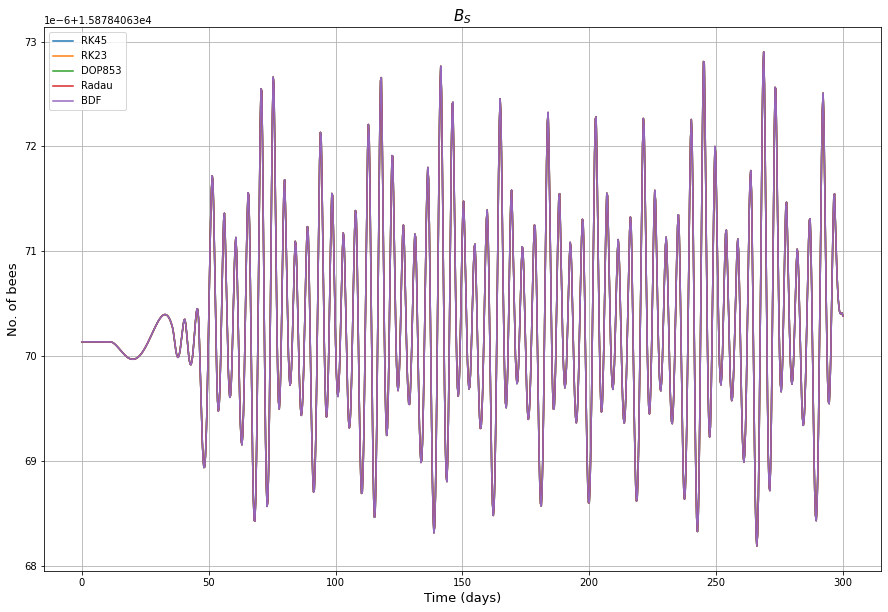

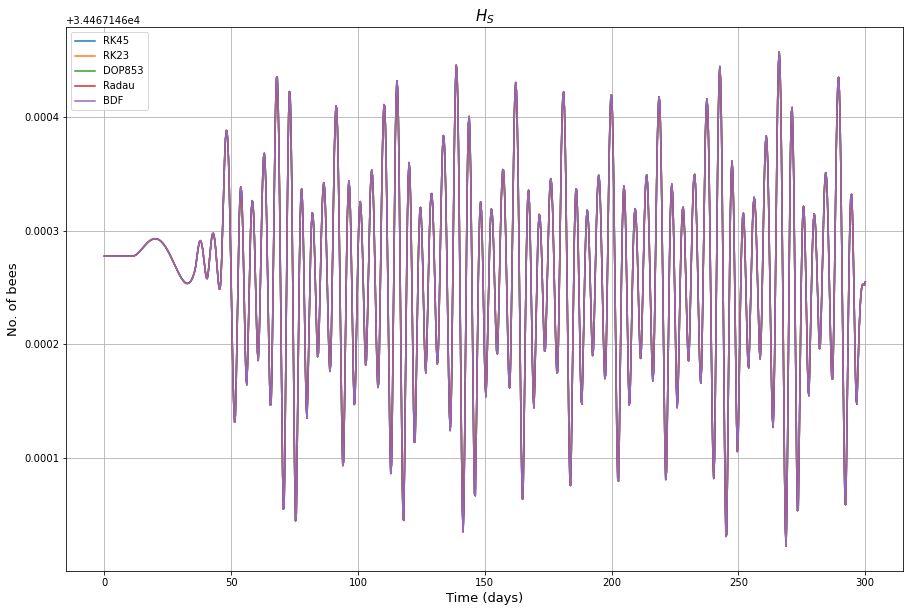

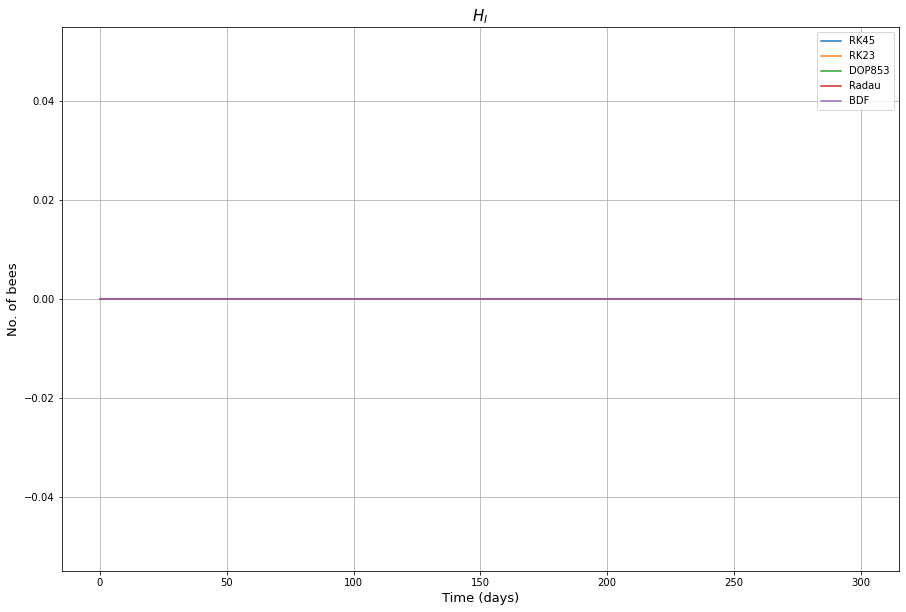

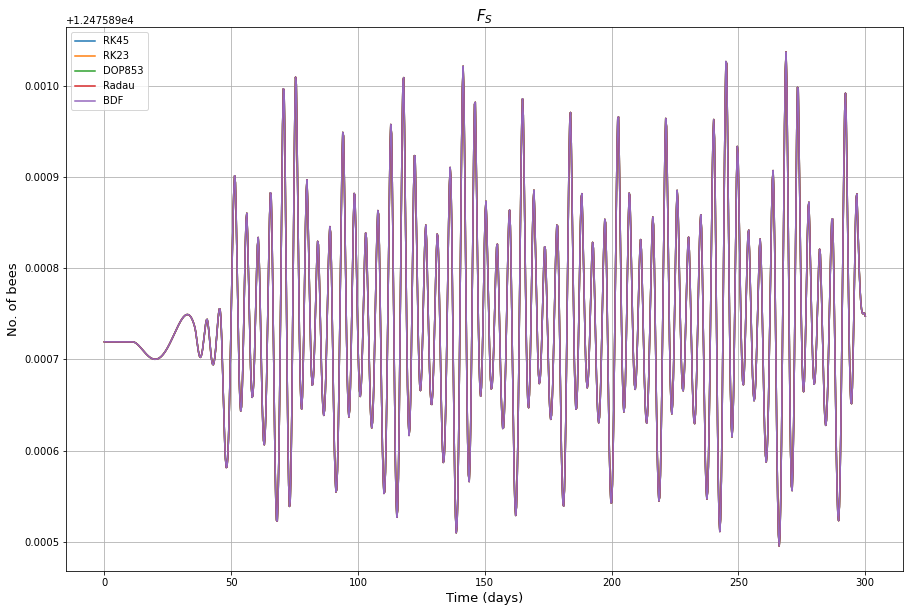

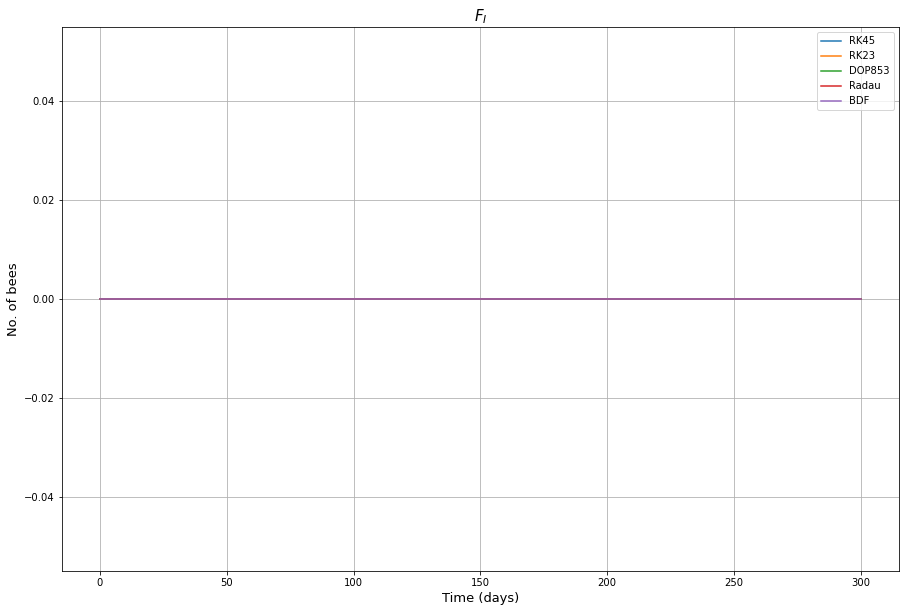

In [5]:
for i in range(len(results)):
    plot_exp0_results(results, my_vars[i])
del i

In [6]:
del methods, results, plot_exp0_results

The choice of algorithms are practically irrelevant. Let's stick with ```"DOP853"```. For more information on ```scipy.integrate.solve_ivp```, see its [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html).

# Experiment 1
- 300 days @ 5000 time steps
- default initial values

In [7]:
# Parameters
params = {
    "d_B" : 1, "d_H" : 0.14, "d_F" : 0.14,
    "L" : 2.0e3, "m" : 0.14, "R_b" : 0.25, "w" : 5.0e3,
    "alpha_F" : 0.75, "beta_BH" : 5.0e-5, "beta_HH" : 5.0e-5, "beta_HF" : 5.0e-5, 
    "beta_FH" : 5.0e-5, "beta_FF" : 5.0e-5, "phi" : 0.11
}
params["epsilon"] = params["m"] + params["alpha_F"] - params["R_b"]

# Numerical solution stuff
t_span = (0, 300)
t_eval = numpy.linspace(t_span[0], t_span[1], 5000)
rtol, atol = 1e-8, 1e-10
method = "DOP853"

# Initial values
Bs = ((2*params["L"] + params["w"]*params["epsilon"]) - params["w"]*numpy.sqrt(params["epsilon"]**2 + 4*params["m"]*params["R_b"])) / (2*params["phi"])
Hs = ((2*params["L"] + params["w"]*params["epsilon"]) - params["w"]*numpy.sqrt(params["epsilon"]**2 + 4*params["m"]*params["R_b"])) / (numpy.sqrt(params["epsilon"]**2 + 4*params["m"]*params["R_b"]) - params["epsilon"])
Fs = ((2*params["L"] + params["w"]*params["epsilon"]) - params["w"]*numpy.sqrt(params["epsilon"]**2 + 4*params["m"]*params["R_b"])) / (2*params["m"])
Hi, Fi = 0, 0
X_start = numpy.array([Bs, Hs, Hi, Fs, Fi])
del Bs, Hs, Hi, Fs, Fi

In [8]:
# Utility function for plotting result
def plot_result(result, vars_to_plot, x_lims=None, y_lims=None):
    fig = pyplot.figure(figsize=(15,10))
    pyplot.title("Bee populations over time", fontsize=15)
    pyplot.xlabel("Time (days)", fontsize=13)
    pyplot.ylabel("No. of bees", fontsize=13)
    pyplot.grid(b=True, which="both", axis="both")
    
    for var_to_plot in vars_to_plot:
        pyplot.plot(result.t, result.y[var_to_plot[1],:], label="$"+var_to_plot[0]+"$")
    
    if x_lims is not None:
        pyplot.xlim((min(x_lims), max(x_lims)))
    if y_lims is not None:
        pyplot.ylim((min(y_lims), max(y_lims)))
    
    pyplot.legend(loc="best")
    
    del fig, result, vars_to_plot, var_to_plot, x_lims, y_lims

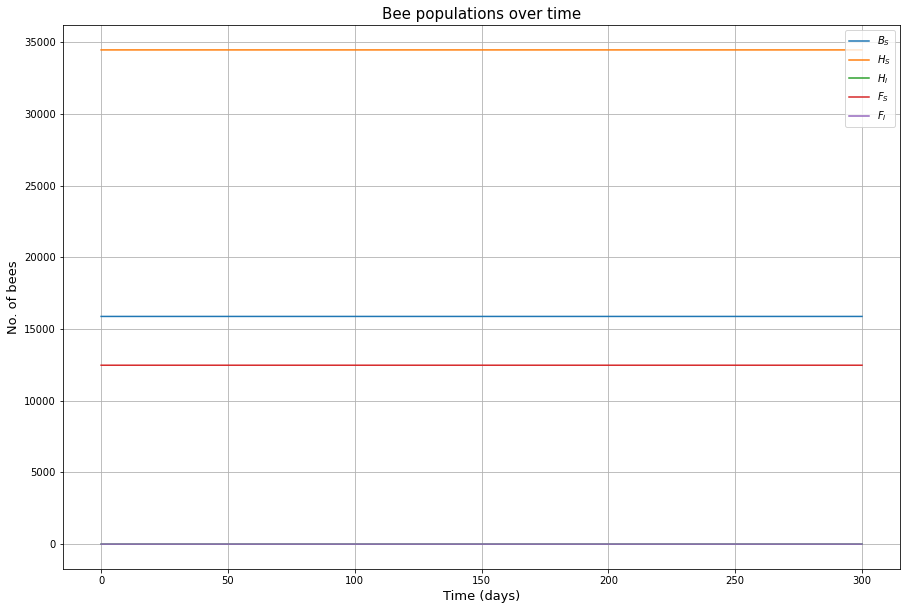

In [9]:
result = solve_ivp(calc_dXdt, t_span, X_start, method=method, t_eval=t_eval, rtol=rtol, atol=atol)
plot_result(result, my_vars[:], x_lims=None, y_lims=None)

In [10]:
# Housekeeping
del result

Equilibrium values: $B_S \approx 15,879$, $H_S \approx 34,467$, $H_I \approx 0$, $F_S \approx 12,476$, $F_I \approx 0$.

# Experiment 2
- 300 days @ 5000 time steps
- $F_I \left(0\right) = 0.15 F_S \left(0\right)$

In [11]:
# Parameters
params = {
    "d_B" : 1, "d_H" : 0.14, "d_F" : 0.14,
    "L" : 2.0e3, "m" : 0.14, "R_b" : 0.25, "w" : 5.0e3,
    "alpha_F" : 0.75, "beta_BH" : 5.0e-5, "beta_HH" : 5.0e-5, "beta_HF" : 5.0e-5, 
    "beta_FH" : 5.0e-5, "beta_FF" : 5.0e-5, "phi" : 0.11
}
params["epsilon"] = params["m"] + params["alpha_F"] - params["R_b"]

# Numerical solution stuff
t_span = (0, 300)
t_eval = numpy.linspace(t_span[0], t_span[1], 5000)
rtol, atol = 1e-8, 1e-10
method = "DOP853"

# Initial values
Bs = ((2*params["L"] + params["w"]*params["epsilon"]) - params["w"]*numpy.sqrt(params["epsilon"]**2 + 4*params["m"]*params["R_b"])) / (2*params["phi"])
Hs = ((2*params["L"] + params["w"]*params["epsilon"]) - params["w"]*numpy.sqrt(params["epsilon"]**2 + 4*params["m"]*params["R_b"])) / (numpy.sqrt(params["epsilon"]**2 + 4*params["m"]*params["R_b"]) - params["epsilon"])
Fs = ((2*params["L"] + params["w"]*params["epsilon"]) - params["w"]*numpy.sqrt(params["epsilon"]**2 + 4*params["m"]*params["R_b"])) / (2*params["m"])
Hi, Fi = 0, numpy.ceil(0.15*Fs)
X_start = numpy.array([Bs, Hs, Hi, Fs, Fi])
del Bs, Hs, Hi, Fs, Fi

In [12]:
result = solve_ivp(calc_dXdt, t_span, X_start, method=method, t_eval=t_eval, rtol=rtol, atol=atol)

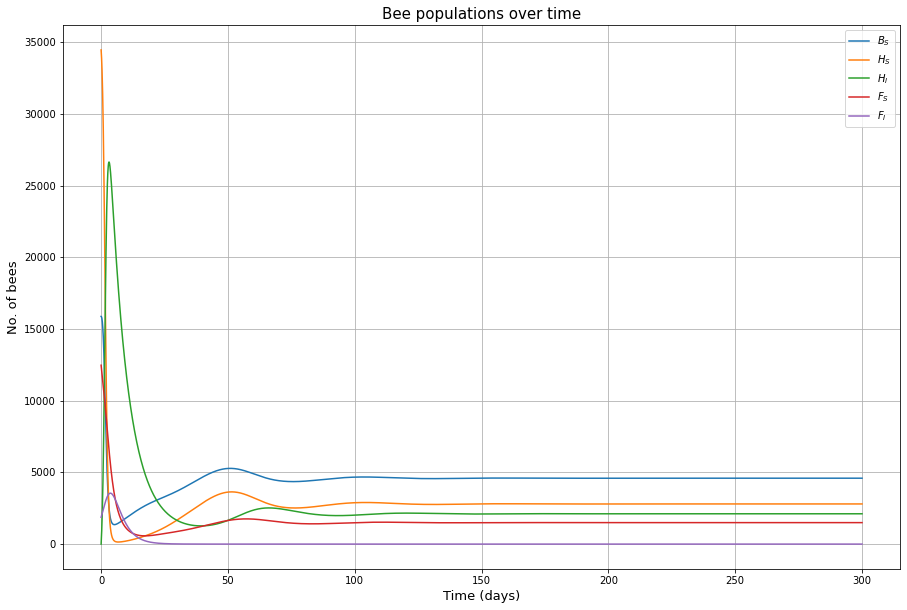

In [13]:
plot_result(result, my_vars[:], x_lims=None, y_lims=None)

In [14]:
# Housekeeping
del result

Equilibrium values: $B_S \approx 4,596$, $H_S \approx 2,800$, $H_I \approx 2,114$, $F_S \approx 1,497$, $F_I \approx 0$. Consider playing around with $F_I \left(0\right)$.

# Experiment 3
- 300 days @ 5000 time steps
- $H_I \left(0\right) = 0.15 H_S \left(0\right)$

In [15]:
# Parameters
params = {
    "d_B" : 1, "d_H" : 0.14, "d_F" : 0.14,
    "L" : 2.0e3, "m" : 0.14, "R_b" : 0.25, "w" : 5.0e3,
    "alpha_F" : 0.75, "beta_BH" : 5.0e-5, "beta_HH" : 5.0e-5, "beta_HF" : 5.0e-5, 
    "beta_FH" : 5.0e-5, "beta_FF" : 5.0e-5, "phi" : 0.11
}
params["epsilon"] = params["m"] + params["alpha_F"] - params["R_b"]

# Numerical solution stuff
t_span = (0, 300)
t_eval = numpy.linspace(t_span[0], t_span[1], 5000)
rtol, atol = 1e-8, 1e-10
method = "DOP853"

# Initial values
Bs = ((2*params["L"] + params["w"]*params["epsilon"]) - params["w"]*numpy.sqrt(params["epsilon"]**2 + 4*params["m"]*params["R_b"])) / (2*params["phi"])
Hs = ((2*params["L"] + params["w"]*params["epsilon"]) - params["w"]*numpy.sqrt(params["epsilon"]**2 + 4*params["m"]*params["R_b"])) / (numpy.sqrt(params["epsilon"]**2 + 4*params["m"]*params["R_b"]) - params["epsilon"])
Fs = ((2*params["L"] + params["w"]*params["epsilon"]) - params["w"]*numpy.sqrt(params["epsilon"]**2 + 4*params["m"]*params["R_b"])) / (2*params["m"])
Hi, Fi = numpy.ceil(0.15*Hs), 0
X_start = numpy.array([Bs, Hs, Hi, Fs, Fi])
del Bs, Hs, Hi, Fs, Fi

In [16]:
result = solve_ivp(calc_dXdt, t_span, X_start, method=method, t_eval=t_eval, rtol=rtol, atol=atol)

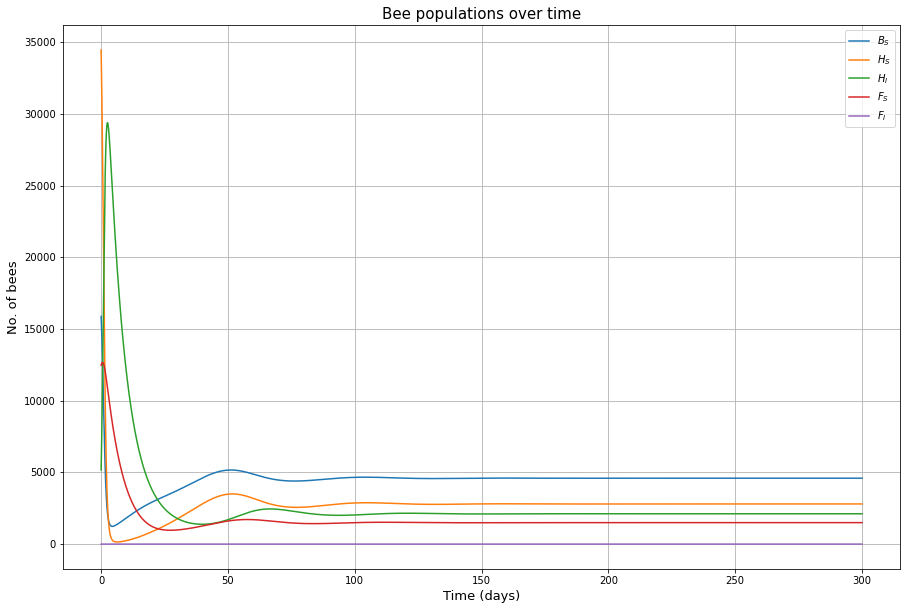

In [17]:
plot_result(result, my_vars[:], x_lims=None, y_lims=None)

In [18]:
# Housekeeping
del result

Equilibrium values: $B_S \approx 4,596$, $H_S \approx 2,800$, $H_I \approx 2,114$, $F_S \approx 1,497$, $F_I = 0$. Consider playing around with $H_I \left(0\right)$.

Notice that the equilibria for Experiments 2 and 3 are practically equal. Let's try setting both $H_I\left(0\right)$ and $F_I\left(0\right)$ to nonzero values.

# Experiment 4
- 300 days @ 5000 time steps
- $F_I \left(0\right) = 0.15 F_S \left(0\right)$
- $H_I \left(0\right) = 0.15 H_S \left(0\right)$

In [19]:
# Parameters
params = {
    "d_B" : 1, "d_H" : 0.14, "d_F" : 0.14,
    "L" : 2.0e3, "m" : 0.14, "R_b" : 0.25, "w" : 5.0e3,
    "alpha_F" : 0.75, "beta_BH" : 5.0e-5, "beta_HH" : 5.0e-5, "beta_HF" : 5.0e-5, 
    "beta_FH" : 5.0e-5, "beta_FF" : 5.0e-5, "phi" : 0.11
}
params["epsilon"] = params["m"] + params["alpha_F"] - params["R_b"]

# Numerical solution stuff
t_span = (0, 300)
t_eval = numpy.linspace(t_span[0], t_span[1], 5000)
rtol, atol = 1e-8, 1e-10
method = "DOP853"

# Initial values
Bs = ((2*params["L"] + params["w"]*params["epsilon"]) - params["w"]*numpy.sqrt(params["epsilon"]**2 + 4*params["m"]*params["R_b"])) / (2*params["phi"])
Hs = ((2*params["L"] + params["w"]*params["epsilon"]) - params["w"]*numpy.sqrt(params["epsilon"]**2 + 4*params["m"]*params["R_b"])) / (numpy.sqrt(params["epsilon"]**2 + 4*params["m"]*params["R_b"]) - params["epsilon"])
Fs = ((2*params["L"] + params["w"]*params["epsilon"]) - params["w"]*numpy.sqrt(params["epsilon"]**2 + 4*params["m"]*params["R_b"])) / (2*params["m"])
Hi, Fi = numpy.ceil(0.15*Hs), numpy.ceil(0.15*Fs)
X_start = numpy.array([Bs, Hs, Hi, Fs, Fi])
del Bs, Hs, Hi, Fs, Fi

In [20]:
result = solve_ivp(calc_dXdt, t_span, X_start, method=method, t_eval=t_eval, rtol=rtol, atol=atol)

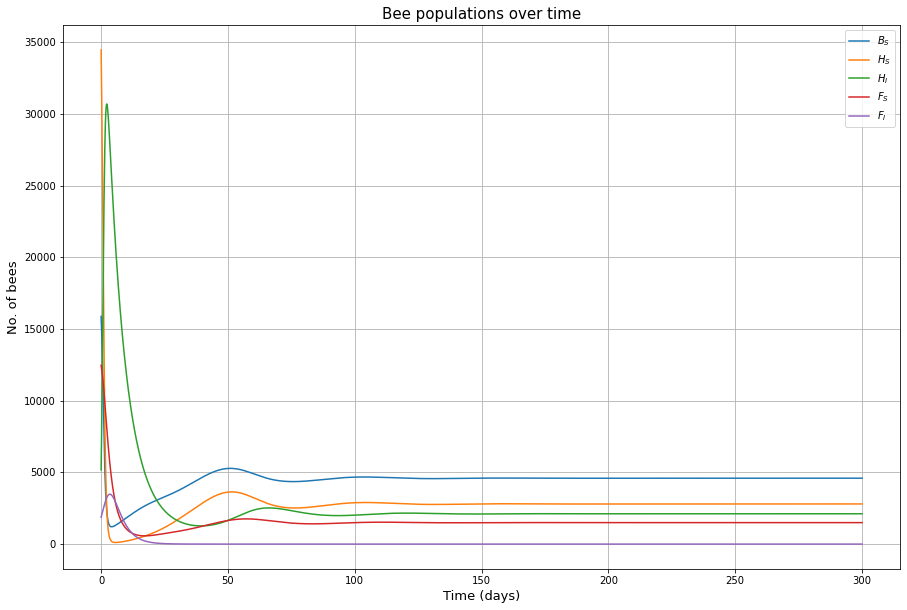

In [21]:
plot_result(result, my_vars[:], x_lims=None, y_lims=None)

In [22]:
# Housekeeping
del result

Equilibrium values: $B_S \approx 4,596$, $H_S \approx 2,800$, $H_I \approx 2,114$, $F_S \approx 1,497$, $F_I \approx 0$. Consider modifying $H_I \left(0\right)$ and $F_I \left(0\right)$.

These are equal to those obtained in Experiments 2 and 3.

# Experiment 5
- first period: 300 days @ 5000 time steps
 - $F_I \left(0\right) = 0.15 F_S \left(0\right)$
- second period: 300 days @ 5000 time steps
 - use $B_S$, $H_S$, $F_S$, $F_I$ at $ t = 300$ as initial values
 - $H_I \left(300\right) = 0.15 H_S \left(300\right)$

In [23]:
# Parameters
params = {
    "d_B" : 1, "d_H" : 0.14, "d_F" : 0.14,
    "L" : 2.0e3, "m" : 0.14, "R_b" : 0.25, "w" : 5.0e3,
    "alpha_F" : 0.75, "beta_BH" : 5.0e-5, "beta_HH" : 5.0e-5, "beta_HF" : 5.0e-5, 
    "beta_FH" : 5.0e-5, "beta_FF" : 5.0e-5, "phi" : 0.11
}
params["epsilon"] = params["m"] + params["alpha_F"] - params["R_b"]

# Numerical solution stuff
rtol, atol = 1e-8, 1e-10
method = "DOP853"

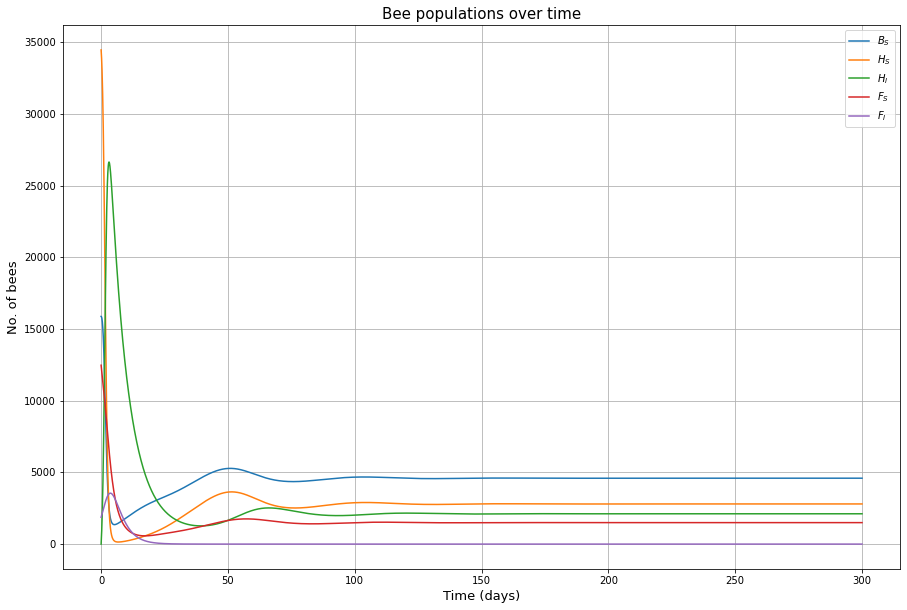

In [24]:
# First period
Bs = ((2*params["L"] + params["w"]*params["epsilon"]) - params["w"]*numpy.sqrt(params["epsilon"]**2 + 4*params["m"]*params["R_b"])) / (2*params["phi"])
Hs = ((2*params["L"] + params["w"]*params["epsilon"]) - params["w"]*numpy.sqrt(params["epsilon"]**2 + 4*params["m"]*params["R_b"])) / (numpy.sqrt(params["epsilon"]**2 + 4*params["m"]*params["R_b"]) - params["epsilon"])
Fs = ((2*params["L"] + params["w"]*params["epsilon"]) - params["w"]*numpy.sqrt(params["epsilon"]**2 + 4*params["m"]*params["R_b"])) / (2*params["m"])
Hi, Fi = 0, numpy.ceil(0.15*Fs)
X_start_period_1 = numpy.array([Bs, Hs, Hi, Fs, Fi])
del Bs, Hs, Hi, Fs, Fi

t_span_period_1 = (0, 300)
t_eval_period_1 = numpy.linspace(t_span_period_1[0], t_span_period_1[1], 5000)

result_period_1 = solve_ivp(calc_dXdt, t_span_period_1, X_start_period_1, method=method, t_eval=t_eval_period_1, rtol=rtol, atol=atol)
plot_result(result_period_1, my_vars[:], x_lims=None, y_lims=None)

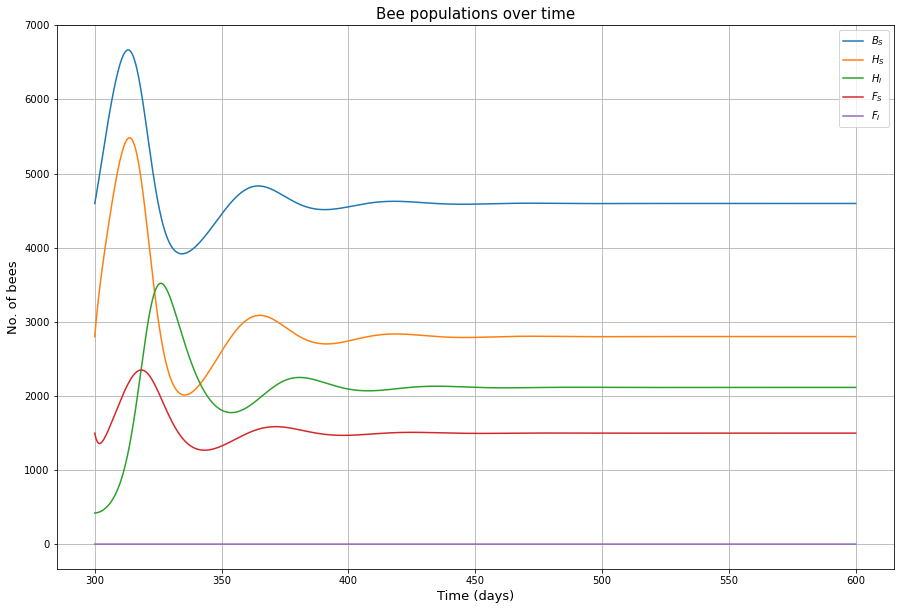

In [25]:
# Second period
X_start_period_2 = result_period_1.y[:,-1]
X_start_period_2[2] = 0.15*result_period_1.y[1,-1]

t_span_period_2 = (300, 600)
t_eval_period_2 = numpy.linspace(t_span_period_2[0], t_span_period_2[1], 5000)

result_period_2 = solve_ivp(calc_dXdt, t_span_period_2, X_start_period_2, method=method, t_eval=t_eval_period_2, rtol=rtol, atol=atol)
plot_result(result_period_2, my_vars[:], x_lims=None, y_lims=None)

In [26]:
# Housekeeping
del result_period_1, result_period_2

Consider varying some parameters (<i>e.g.</i>, $d$'s, $L$, $m$, $\beta$'s, and $\phi$) at different periods to mimic seasonal effects.

# Final thoughts
Consider replicating the figures in the 2014 paper, [<i>Effects of Infection on Honey Bee Population Dynamics: A Model</i>](https://doi.org/10.1371/journal.pone.0110237) by M. I. Betti, L. M. Wahl, and M. Zamir.